##### --- Preliminaries --- 

In [98]:
from datetime import datetime, timezone, timedelta
import requests
import pandas as pd
import pandas_datareader as pdr
import numpy as np
from datetime import datetime
import datetime as dt
import scipy
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib import dates
import matplotlib.dates as mdates
import ipywidgets as widgets
import warnings
warnings.filterwarnings("ignore")
import copy
import matplotlib.colors as mcolors
import seaborn as sns
sns.set(color_codes=True, font_scale=1.2)
import pickle
from PIL import Image


from heatmap import heatmap, corrplot

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from arch.univariate import arch_model
from arch import arch_model
from sklearn.metrics import mean_squared_error



# !pip install pmdarima
# !pip install arch


# Crypto Risk and VaR Analysis

## Fetching Data

### Crypto Data

In [2]:
# Get the symbols


LIMIT = 100  # <= 9999

url = f"https://api.coinmarketcap.com/data-api/v3/cryptocurrency/listing?start=&limit={LIMIT}&sortBy=market_cap&sortType=desc&convert=USD&cryptoType=all&tagType=all&audited=false"

r = requests.get(url)

data = r.json().get('data', [])

symbols = [coin['symbol'] for coin in data['cryptoCurrencyList']]

In [3]:
# Fetch the daily historical price data for the symbols

today = datetime.today()

DATE_FIRST, DATE_LAST = today - timedelta(weeks=260), today

dfs = []
failed = []

In [ ]:
for symbol in symbols:
    try:
        df = pdr.DataReader(
            f"{symbol}-USD", 
            'yahoo', 
            DATE_FIRST,
            DATE_LAST
        )
    except KeyError:
        failed.append(symbol)
        continue
    print(symbol, len(df))
    df['Symbol'] = symbol
    dfs.append(df)

df = pd.concat(dfs)
df.reset_index(inplace=True)
df.set_index(['Symbol', 'Date'], inplace=True)
#df.tail()

In [5]:
# Write to CSV


#df.to_csv(f"crypto-top{LIMIT}.csv")

In [4]:
df = pd.read_csv(f"crypto-top{LIMIT}.csv")
df.set_index(['Symbol', 'Date'], inplace=True)
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(["Symbol", "Date"], inplace=True)
df


High          Low         Open        Close  \
Symbol Date                                                             
BTC    2017-06-29  2588.830078  2510.479980  2567.560059  2539.320068   
       2017-06-30  2559.250000  2478.429932  2539.239990  2480.840088   
       2017-07-01  2515.270020  2419.229980  2492.600098  2434.550049   
       2017-07-02  2514.280029  2394.840088  2436.399902  2506.469971   
       2017-07-03  2595.000000  2480.469971  2498.560059  2564.060059   
...                        ...          ...          ...          ...   
STORJ  2022-06-19     0.590980     0.428774     0.428774     0.529077   
       2022-06-20     0.651067     0.529122     0.529122     0.639277   
       2022-06-21     0.777059     0.639704     0.639704     0.710734   
       2022-06-22     0.729645     0.616497     0.712224     0.616497   
       2022-06-23     0.753365     0.616770     0.616770     0.730266   

                        Volume    Adj Close  
Symbol Date                                  
BTC    2017-06-29  949979008.0  2539.320068  
       2017-06-30  860273024.0  2480.840088  
       2017-07-01  779913984.0  2434.550049  
       2017-07-02  803747008.0  2506.469971  
       2017-07-03  964112000.0  2564.060059  
...                        ...          ...  
STORJ  2022-06-19  210655849.0     0.529077  
       2022-06-20  274718421.0     0.639277  
       2022-06-21  356211809.0     0.710734  
       2022-06-22   75752771.0     0.616497  
       2022-06-23  188166672.0     0.730266  

[119972 rows x 6 columns]

### Market Data

In [5]:
# Fetch the daily historical price data for relevant market data

tickers = [ '^GSPC', '^STOXX', "MME=F", "GC=F", "BZ=F", "CDX", "EURUSD=X", "USDJPY=X", "GBPUSD=X", "EURGBP=X",]
# SP500, Euro Stocks, MSCI World Emerging. Gold, Oil, Credit Default Swaps, Top Currency Pairs

start_date, end_date = today - timedelta(weeks=260), today

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = pdr.DataReader(tickers, 'yahoo', start_date, end_date)
# type(panel_data)

In [6]:
## Convert to a long Multiindex format & change ticker names
# market_data=panel_data.stack()
market_data = pd.read_csv(f"market_data.csv")
market_data
# market_data.reset_index(inplace=True)
# market_data.loc[market_data['Symbols'] == "^GSPC", 'Symbols'] = "SP500"
# market_data.loc[market_data['Symbols'] == "MME=F", 'Symbols'] = "MSCI.WORLD"
# market_data.loc[market_data['Symbols'] == "GC=F", 'Symbols'] = "Gold"
# market_data.loc[market_data['Symbols'] == "BZ=F", 'Symbols'] = "Oil"
# market_data.loc[market_data['Symbols'] == "^STOXX", 'Symbols'] = "STOXX600"
# market_data.loc[market_data['Symbols'] == "EURUSD=X", 'Symbols'] = "EURUSD"
# market_data.loc[market_data['Symbols'] == "USDJPY=X", 'Symbols'] = "USDJPY"
# market_data.loc[market_data['Symbols'] == "GBPUSD=X", 'Symbols'] = "GBPUSD"
# market_data.loc[market_data['Symbols'] == "EURGBP=X", 'Symbols'] = "EURGBP"

market_data.set_index(['Symbols', 'Date'],inplace=True)
market_data = market_data.reset_index()
market_data['Date'] = pd.to_datetime(market_data['Date'])
market_data.set_index(["Symbols", "Date"], inplace=True)
market_data=market_data.sort_values(by=['Symbols', "Date"], ascending = True)

# market_data.to_csv(f"market_data.csv")
# market_data.index.get_level_values(level=0).unique()
market_data

Adj Close       Close        High         Low  \
Symbols Date                                                         
CDX     2022-02-17   24.821434   25.089001   25.270000   25.059999   
        2022-02-18   24.889700   25.158001   25.209999   25.070000   
        2022-02-22   24.822422   25.090000   25.209999   25.040001   
        2022-02-23   24.733385   25.000000   25.160000   25.000000   
        2022-02-24   24.870901   25.139000   25.219999   25.059999   
...                        ...         ...         ...         ...   
USDJPY  2022-06-19  135.276001  135.276001  135.412003  134.548996   
        2022-06-20  135.087006  135.087006  136.328995  134.945007   
        2022-06-21  136.268997  136.268997  136.595001  135.751007   
        2022-06-22  136.024002  136.024002  136.181000  134.294006   
        2022-06-24  135.108002  135.108002  135.304001  134.330002   

                          Open    Volume  
Symbols Date                              
CDX     2022-02-17   25.270000  146800.0  
        2022-02-18   25.080000    3100.0  
        2022-02-22   25.209999    2000.0  
        2022-02-23   25.059999    1300.0  
        2022-02-24   25.219999    1400.0  
...                        ...       ...  
USDJPY  2022-06-19  135.276001       0.0  
        2022-06-20  135.087006       0.0  
        2022-06-21  136.268997       0.0  
        2022-06-22  136.024002       0.0  
        2022-06-24  134.934006       0.0  

[11530 rows x 6 columns]

### Returns

- Compute the Return column for each individual Crypto and market indicator
- Sort into most recent Dates first

In [7]:
df["Return"] = df.groupby(level = "Symbol")["Adj Close"].transform(lambda x: x/x.shift(1)-1)
market_data["Return"] = market_data.groupby(level = "Symbols")["Adj Close"].transform(lambda x: x/x.shift(1)-1)

df = df.sort_values(by=['Symbol', "Date"], ascending = False)

## Subsetting

Split data into various subsets including
- Bitcoin - `btc`
- Etherium - `eth`
- Top 5 coins by market capitalisation - `top_coins`
- Those coins not in `top_coins` - `alt_coins`
- Bitcoin and Etherium with the market data - `coins_with_market`

In [14]:
idx = pd.IndexSlice
btc = df.loc[idx[["BTC"], :], :]
eth = df.loc[idx[["ETH"], :], :]

top_coins = df.reset_index(level=0)
top_coins = top_coins[top_coins['Symbol'].isin(["BTC", "ETH", "USDT", "USDC", "BNB"])].reset_index(level=0)
top_coins.set_index(['Symbol', 'Date'], inplace=True)

alt_coins = df.reset_index(level=0)
alt_coins = alt_coins[~alt_coins['Symbol'].isin(top_coins.
                              index
                              .get_level_values(level=0))].reset_index(level=0)
alt_coins.set_index(['Symbol', 'Date'], inplace=True)

coins_with_market = pd.concat([btc, eth, market_data])

sp500 = coins_with_market.loc[idx[["SP500"], :], :]
gold = coins_with_market.loc[idx[["Gold"], :], :]

## Historical VaR

___
### VaR Function

Define a function which given a DataFrame containing a cryptocurrency's return series calculates the rolling expontenially weighted Historical Value-at-Risk for timeseries of returns for a cryptocurency `Port`, which a smoothing constant `Lambda` and a VaR `alpha`. We define Historical VaR and the variations used as follows.

Given a set of $n$ historical returns $\{r_t\}_{t=0}^{n-1}$ where,

$$r_t = \frac{P_t-P_{t-1}}{P_{t-1}}$$

The steps of historical Value-at-Risk of this asset are:


**Step (1)** - Compute the probabilities assigned to each return

>**Equal weighted**

$$\big\{P(r_t)\big\}_{t=0}^{n-1} =\Big\{\frac{1}{n}\Big\}_{t=0}^{n-1} $$

>**Exponentially weighted** 

$$\big\{P(r_t)\big\}_{t=0}^{n-1} = (1-\lambda)\frac{\lambda^{t}}{1-\lambda^n}$$

Note: both these probability weights sum to 1 an obvious requirement for such a procedure.

We refer to $t$ as the recency of an observation, i.e. $t=0$ is the most recent observation the point which the risk horizon which VaR is to be estimated over begins and $t=n$ is the "least" recent observation and is the earliest observation in the data window.  To visualize the difference in these distributions across the observations we can plot them as a function of recency. Below we can see how more recent observations are assigned greater weight and it quickly drowns out earlier returns. Furthermore, we note how the value of $\lambda$ can be set to allow for varying levels of decay with a lower value drastically diminishing the impact of earlier returns.

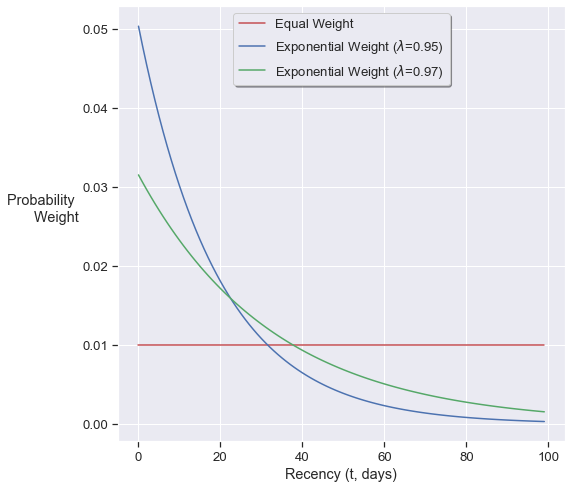

In [8]:
# Number of observations
n = 100
# Decay factor
lambda_1 = 0.95
lambda_2 = 0.97

# Recency of last 100 
x = np.linspace(0,n-1,n)

# equal and exponential probabilities
eq_probability = np.repeat(1/n,n)
exp_probability_1 = (1-lambda_1)* pow(lambda_1,x) / (1-pow(lambda_1,n)) 
exp_probability_2 = (1-lambda_2)* pow(lambda_2,x) / (1-pow(lambda_2,n)) 

# figure params
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.xlabel('Recency (t, days)')
plt.ylabel('Probability \n Weight',
          rotation = 0,
          horizontalalignment = 'right')

# plot the function
plt.plot(x, eq_probability, 'r', x, exp_probability_1, 'b', x, exp_probability_2, 'g')#, exp_p_sum, 'g')
plt.legend(('Equal Weight', f'Exponential Weight ($\lambda$={lambda_1})', f'Exponential Weight ($\lambda$={lambda_2})'),
           loc='upper center', shadow=True)


plt.show()

**Step (2)** - Order the returns from smallest to largest and order their respective equal or weighted probabilities in the same order. 

We use the notation $J$ to represent the new positional order indexing of the return index, in our example here the $4th$ most recent return (i.e. $i=3$) is the lowest return in the historical data window of returns, with the $55th$ being the second lowest and so on. 

$$Ascending\big(\{r_t\}_{t=0}^{n-1}\big) = \{3,55, 78,...,j\} = J$$

$$ \bar{r}_J = \{r_3, r_{55}, r_{78},..., r_j\}$$

Therefore our probabilities order by the same indexing are

$$ P(\bar{r} )_{J}^{}  = \big\{P(r_3), P(r_{55}), P(r_{78}),..., P(r_j)\big\}$$


**Step (3)** - Compute the cumulative probabilities either using the simple approach of the mass centered method described by Allen (2004). 

>**Simple**

$$cumsum(P(\bar{r} )_{J}^{} ) = \big\{P(r_3), P(r_3) + P(r_{55}),..., \sum_{i=j}P(r_j)\big\}$$

which are associated with the ordered return series $\bar{r}_J$.

>**Mass Centered** 

With mass centering the locations of the order observed returns act as its respective probability's mass center. This probability mass is spread between the midpoints its associated return and the two adjacent returns. Therefore, we have a new series of ordered return locations which includes the original observed returns and the the midpoints of this series. Associated with this we have a new series of cumulative probabilities which likewise include the original probabilities but in additional have the spread probabilities.  In notation the mass centered cumulative probability series is written as

$$cumsum(P(\bar{r} )_{J,MC}^{} ) = \big\{\frac{P(r_3)}{2},\ P(r_3),\ P(r_3) + \frac{P(r_{55})}{2},\  P(r_3) + P(r_{55}),\...\big\}$$

which are associated with the ordered mass centered return series

$$\bar{r}_{J,MC}^{} = \big\{r_3,\ \frac{r_{3}+r_{55}}{2},\  r_{55},\ \frac{r_{55}+r_{78}}{2},\ ...\big\}$$

This can be a confusing notion and is best described visually as seen below. The simple approach merely assigns the probabilities to each of the return observations.

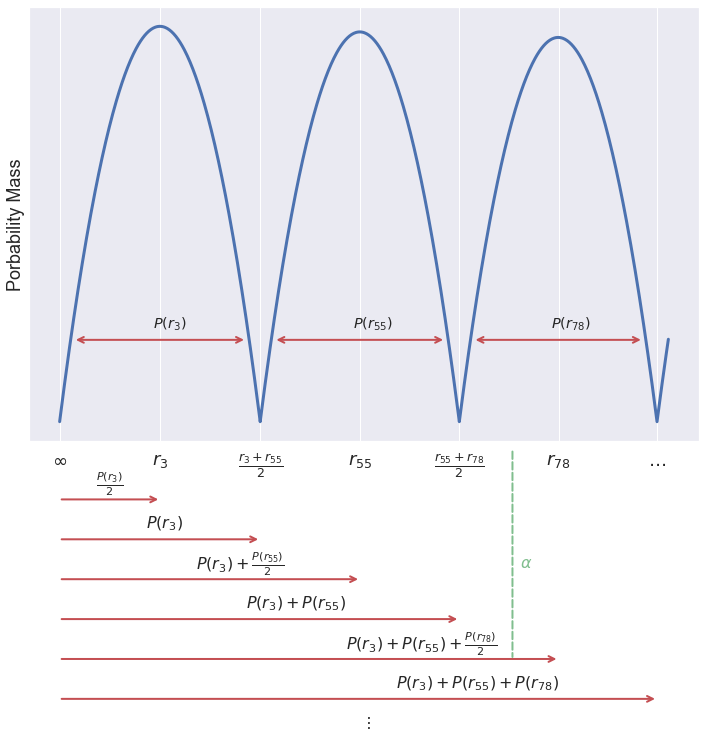

In [9]:
def traj_y_bounce(tmax, v0, y0, e0=1):
    g = 9.9 # meters/s/s
    y = [y0] # heights over time

    dt = 0.01 # integrate in hundredths of a second
    v = v0
    t = 0
    while t <= tmax:
        if y[-1] <= 0 and v < 0:
            v = -e0*v   # reflect off ground
        v = v - g*dt    # integrate velocity
        y.append(y[-1] + v*dt)  # integrate position

        t = t + dt  # integrate time
    return y


y = np.array(traj_y_bounce(10, 0, 10))
y = y[int(np.where(y==min(y[1:150]))[0]):]

fig = plt.figure(figsize=(12, 8))
plt.plot(y, linewidth=3, label='ggg')


tickers = ["$\infty$","$\\frac{r_{3}+r_{55}}{2}$","$\\frac{r_{55}+r_{78}}{2}$","$\dots$"]
tickers2 = ["$r_3$","$r_{55}$","$r_{78}$"]

return_tick= [None]*(len(tickers)+len(tickers2))
return_tick[1::2] = tickers2
return_tick[::2] = tickers

return_mid_points = np.asarray(np.where(y<0)[0][:])
return_points = np.around((return_mid_points[1:] + return_mid_points[:-1]) / 2)

return_tick_loc=[None]*(len(tickers)+len(tickers2))
return_tick_loc[::2] = return_mid_points
return_tick_loc[1::2] = return_points

plt.xticks(return_tick_loc, return_tick, rotation=0)
plt.yticks([])
# plt.tick_params(axis='both', which='major',
#  labelsize=11)
# ticks = plt.xticks(return_points, tickers2, rotation=0)
plt.tick_params(axis='x', which='major', labelsize=18)
# plt.ylabel(axis='both', which='major',
#                 labelsize=18)

plt.ylabel(f"Porbability Mass", fontsize=18)



# Probability Arrows
plt.annotate(xy=(return_tick_loc[0]+20,2), xytext=(return_tick_loc[2]-20,2), arrowprops=dict(arrowstyle='<->', color = "r", linewidth=2),text= "")
plt.annotate( xy=(return_tick_loc[1]-10,2.4),text= "$P(r_3)$", va="center")
plt.annotate(xy=(return_tick_loc[2]+20,2), xytext=(return_tick_loc[4]-20,2), arrowprops=dict(arrowstyle='<->', color = "r", linewidth=2),text= "")
plt.annotate( xy=(return_tick_loc[3]-10,2.4),text= "$P(r_{55})$", va="center")
plt.annotate(xy=(return_tick_loc[4]+20,2), xytext=(return_tick_loc[6]-20,2), arrowprops=dict(arrowstyle='<->', color = "r", linewidth=2),text= "")
plt.annotate( xy=(return_tick_loc[5]-10,2.4),text= "$P(r_{78})$", va="center")

plt.annotate(xy=(return_tick_loc[0]+0,-2), xytext=(return_tick_loc[1]-0,-2),
             arrowprops=dict(arrowstyle='<-', color = "r", linewidth=2),text= "", xycoords='data', annotation_clip=False)
plt.annotate(xy=((return_tick_loc[0]+return_tick_loc[1])/2-20,-1.6),text= "$\\frac{P(r_3)}{2}$", va="center", xycoords='data', annotation_clip=False,
             fontsize=16)
plt.annotate(xy=(return_tick_loc[0]+0,-3), xytext=(return_tick_loc[2]-0,-3),
             arrowprops=dict(arrowstyle='<-', color = "r", linewidth=2),text= "", xycoords='data', annotation_clip=False)
plt.annotate(xy=((return_tick_loc[1]+return_tick_loc[1])/2-20,-2.6),text= "$P(r_3)$", va="center", xycoords='data', annotation_clip=False,
             fontsize=16)
plt.annotate(xy=(return_tick_loc[0]+0,-4), xytext=(return_tick_loc[3]-0,-4),
             arrowprops=dict(arrowstyle='<-', color = "r", linewidth=2),text= "", xycoords='data', annotation_clip=False)
plt.annotate(xy=((return_tick_loc[1]+return_tick_loc[2])/2-20,-3.6),text= "$P(r_3)+\\frac{P(r_{55})}{2}$", va="center", xycoords='data', annotation_clip=False,
             fontsize=16)
plt.annotate(xy=(return_tick_loc[0]+0,-5), xytext=(return_tick_loc[4]-0,-5),
             arrowprops=dict(arrowstyle='<-', color = "r", linewidth=2),text= "", xycoords='data', annotation_clip=False)
plt.annotate(xy=((return_tick_loc[2]+return_tick_loc[2])/2-20,-4.6),text= "$P(r_3)+P(r_{55})$", va="center", xycoords='data', annotation_clip=False,
             fontsize=16)
plt.annotate(xy=(return_tick_loc[0]+0,-6), xytext=(return_tick_loc[5]-0,-6),
             arrowprops=dict(arrowstyle='<-', color = "r", linewidth=2),text= "", xycoords='data', annotation_clip=False)
plt.annotate(xy=((return_tick_loc[3]+return_tick_loc[3])/2-20,-5.6),text= "$P(r_3)+P(r_{55})+\\frac{P(r_{78})}{2}$", va="center", xycoords='data', annotation_clip=False,
             fontsize=16)
plt.annotate(xy=(return_tick_loc[0]+0,-7), xytext=(return_tick_loc[6]-0,-7),
             arrowprops=dict(arrowstyle='<-', color = "r", linewidth=2),text= "", xycoords='data', annotation_clip=False)
plt.annotate(xy=((return_tick_loc[3]+return_tick_loc[4])/2-20,-6.6),text= "$P(r_3)+P(r_{55})+P(r_{78})$", va="center", xycoords='data', annotation_clip=False,
             fontsize=16)

plt.annotate(xy=(return_tick_loc[3]-0,-7.6),text= "$\\vdots$", va="center", xycoords='data', annotation_clip=False,
             fontsize=16)

# alpha line
plt.annotate(xy=((return_tick_loc[4]+return_tick_loc[5])/2+5,-6), xytext=((return_tick_loc[4]+return_tick_loc[5])/2+5,-0.75),
             arrowprops=dict(arrowstyle='-',linestyle='--', color = "g", linewidth=2, alpha=0.75),text= "", xycoords='data', annotation_clip=False, alpha=0.75)
plt.annotate(xy=((return_tick_loc[4]+return_tick_loc[5])/2+5+10,-3.6),text= "$\\alpha$", va="center", xycoords='data', annotation_clip=False,
             fontsize=16, color ='g', alpha =0.75)

plt.show()

**Step (4)** - Interpolate the cumulative probabilities and return series to fin the VaR level for a given confidence level of $100(1-\alpha)\%$

Given either the simple approach series' of $\bar{r}_{J}^{}$ and $cumsum(P(\bar{r} )_{J}^{} )$ or the mass centered return and probability series of $\bar{r}_{J,MC}^{}$ and $cumsum(P(\bar{r} )_{J,MC}^{} )$, the return (VaR) associated with a given probability $\alpha$ is calculated via simple linear interpolation. Visually in the chart the VaR value lies somewhere between $\frac{r_{55}+r_{78}}{2}$ and $r_{78}$. 
___

We define the function below which can compute the rolling VaR under **Steps (1)-(4)** above for a given series of returns and the following arguments

 - $r_t$ - series of returns
 - $\alpha$ - critical level of VaR
 - $history$ - size of historical window to use in each lookback window
 - $\lambda$ - exponential probability weighting decay factor
 - Choice of `equal probabilities` or `exponentially weighted`
 - Choice of `simple` or `mass centered` interpolation


### Fucntion Code

In [10]:
def weighted_hist_VaR(coin, alpha, history, lambda_,exponential_weighted=True, mass_centered=True):

    coin = pd.DataFrame(coin)
    coin=coin.sort_values(by=["Date"], ascending = False)
    i=0
    VaR_column = np.repeat(float("NaN"), history)

    while coin.iloc[-(history+i+1):-(1+i),:].shape[0] == history:
        
        port = coin.iloc[-(history+i+1):-(1+i),:]
        
        # Number of observations for a crypto
        k = port.shape[0]

        # Compute the equally weighted and exponentially weighted probabilites
        port.loc[port.index,"equal_prob"] = 1/k
        # Compute Receny
        port["Recency"] = port[["Return"]].apply(lambda x: np.arange(len(x)), axis=0)
        # Weighted probabilites are done so with respect to how 'recent' and observation is, more recent is assigned more weight
        port.loc[port.index,"weighted_prob"] = (1-lambda_)*(pow(lambda_,port.loc[port.index,"Recency"]-1)/(1-pow(lambda_,k)))
       
        # Rank the returns from lowest to highest, the key step in Historical VaR estimation
        port = port.sort_values(by="Return")
       
        # Compute the equally weighted and exponentially weighted cumulative probabilites
        port["cumul_equal_prob"] = port['equal_prob'].cumsum()
        port['cumul_weighted_prob'] = port['weighted_prob'].cumsum()

        # Capture the cumulative probabilites and corresponding crypto returns
        returns = np.array(port["Return"])

        ## EXP-WEIGHTED VAR
        if exponential_weighted:

            cumul_weighted_prob = np.array(port["cumul_weighted_prob"])

            ## MASS CENTERED VAR 
            if mass_centered:
                # Construct and array to the corresponding midpoints
                cumul_weighted_prob_mid = (cumul_weighted_prob[:-1] + cumul_weighted_prob[1:])/2
                returns_mid = (returns[:-1] + returns[1:])/2

                # construct array to hold cumuulative probabilities, their returnsa and resepctive midpoints
                cumul_weighted_prob_mass_center = [None]*(len(cumul_weighted_prob)+len(cumul_weighted_prob_mid))
                returns_mass_center = [None]*(len(returns)+len(returns_mid))

                # Concatenate the midpoint to their respective arrays also adding the first value of 0% and -Inf
                cumul_weighted_prob_mass_center[::2] = cumul_weighted_prob
                cumul_weighted_prob_mass_center[1::2] = cumul_weighted_prob_mid
                cumul_weighted_prob_mass_center = [0] + cumul_weighted_prob_mass_center
                returns_mass_center[::2] = returns
                returns_mass_center[1::2] = returns_mid
                returns_mass_center = [float("Inf")] + returns_mass_center

                # Interpolation to find the alpha% correpsoning Return
                x = cumul_weighted_prob_mass_center
                y = returns_mass_center
                mass_center_exponential_VaR_interpolator = interpolate.interp1d(x, y)

                # Interpolationg for alpha
                VaR = mass_center_exponential_VaR_interpolator(alpha)
                
                VaR_column = np.append(VaR, VaR_column)
                i = i+1

            # STANDARD Weighted VAR
            else:
                # Interpolation to find the alpha% correpsoning Return
                x = cumul_weighted_prob
                y = returns
                exponential_VaR_interpolator = interpolate.interp1d(x, y)

                # Interpolationg for alpha
                VaR = exponential_VaR_interpolator(alpha)
                
                VaR_column = np.append(VaR, VaR_column)
                i = i+1
   

        ## EQUALLY WEIGHTED VAR 
        else:
            cumul_equal_prob = np.array(port["cumul_equal_prob"])

            # Interpolation to find the alpha% correpsoning Return
            x = cumul_equal_prob
            y = returns
            VaR_interpolator = interpolate.interp1d(x, y)

            # Interpolationg for alpha
            VaR = VaR_interpolator(alpha)
        
            VaR_column = np.append(VaR, VaR_column)
            i = i+1
    coin_with_var=copy.copy(coin)
    ## EXP-WEIGHTED VAR
    if exponential_weighted:

        ## MASS CENTERED VAR 
        if mass_centered:


            coin_with_var["ExpW_mc VaR"] = VaR_column

        # STANDARD Weighted VAR
        else:

            coin_with_var["ExpW VaR"] = VaR_column

    ## EQUALLY WEIGHTED VAR 
    else:
        
        coin_with_var["EqW VaR"] = VaR_column
    
    return coin_with_var


### Testing Historical VaR

Test our VaR model on one coin (BTC) for a rolloing window, a critical value of 5% and a lambda 0.98

Test function on `BTC` crypto to produce rolling VaR estimates for 

In [15]:
# btc = weighted_hist_VaR(btc, alpha=0.05, history = 500, lambda_ = 0.98, exponential_weighted=False, mass_centered=False)
# #btc = weighted_hist_VaR(btc, alpha=0.05, history = 500, lambda_ = 0.98, exponential_weighted=True, mass_centered=False)
# btc = weighted_hist_VaR(btc, alpha=0.05, history = 500, lambda_ = 0.98, exponential_weighted=True, mass_centered=True)
# btc.to_csv("btc_hist_var.csv")

High           Low          Open         Close  \
Symbol Date                                                                 
BTC    2022-06-23  20579.384766  19950.117188  19950.117188  20471.808594   
       2022-06-22  20835.750000  19848.078125  20719.414062  19987.029297   
       2022-06-21  21620.628906  20415.062500  20594.294922  20710.597656   
       2022-06-20  20913.322266  19689.169922  20553.371094  20599.537109   
       2022-06-19  20683.822266  18067.152344  19010.902344  20553.271484   
...                         ...           ...           ...           ...   
       2017-07-03   2595.000000   2480.469971   2498.560059   2564.060059   
       2017-07-02   2514.280029   2394.840088   2436.399902   2506.469971   
       2017-07-01   2515.270020   2419.229980   2492.600098   2434.550049   
       2017-06-30   2559.250000   2478.429932   2539.239990   2480.840088   
       2017-06-29   2588.830078   2510.479980   2567.560059   2539.320068   

                         Volume     Adj Close    Return   EqW VaR  ExpW_mc VaR  
Symbol Date                                                                     
BTC    2022-06-23  2.884230e+10  20471.808594  0.024255 -0.064181    -0.079413  
       2022-06-22  2.857479e+10  19987.029297 -0.034937 -0.064181    -0.079857  
       2022-06-21  2.897021e+10  20710.597656  0.005391 -0.064181    -0.080293  
       2022-06-20  3.081846e+10  20599.537109  0.002251 -0.064181    -0.080720  
       2022-06-19  3.532994e+10  20553.271484  0.080748 -0.064181    -0.081139  
...                         ...           ...       ...       ...          ...  
       2017-07-03  9.641120e+08   2564.060059  0.022977       NaN          NaN  
       2017-07-02  8.037470e+08   2506.469971  0.029541       NaN          NaN  
       2017-07-01  7.799140e+08   2434.550049 -0.018659       NaN          NaN  
       2017-06-30  8.602730e+08   2480.840088 -0.023030       NaN          NaN  
       2017-06-29  9.499790e+08   2539.320068       NaN       NaN          NaN  

[1821 rows x 9 columns]

In [109]:
btc = pd.read_csv("btc_hist_var.csv")
btc['Date'] = pd.to_datetime(btc['Date'])
btc.set_index(["Symbol", "Date"], inplace=True)
btc

High           Low          Open         Close  \
Symbol Date                                                                 
BTC    2022-06-23  20579.384766  19950.117188  19950.117188  20471.808594   
       2022-06-22  20835.750000  19848.078125  20719.414062  19987.029297   
       2022-06-21  21620.628906  20415.062500  20594.294922  20710.597656   
       2022-06-20  20913.322266  19689.169922  20553.371094  20599.537109   
       2022-06-19  20683.822266  18067.152344  19010.902344  20553.271484   
...                         ...           ...           ...           ...   
       2017-07-03   2595.000000   2480.469971   2498.560059   2564.060059   
       2017-07-02   2514.280029   2394.840088   2436.399902   2506.469971   
       2017-07-01   2515.270020   2419.229980   2492.600098   2434.550049   
       2017-06-30   2559.250000   2478.429932   2539.239990   2480.840088   
       2017-06-29   2588.830078   2510.479980   2567.560059   2539.320068   

                         Volume     Adj Close    Return   EqW VaR  ExpW_mc VaR  
Symbol Date                                                                     
BTC    2022-06-23  2.884230e+10  20471.808594  0.024255 -0.064181    -0.079413  
       2022-06-22  2.857479e+10  19987.029297 -0.034937 -0.064181    -0.079857  
       2022-06-21  2.897021e+10  20710.597656  0.005391 -0.064181    -0.080293  
       2022-06-20  3.081846e+10  20599.537109  0.002251 -0.064181    -0.080720  
       2022-06-19  3.532994e+10  20553.271484  0.080748 -0.064181    -0.081139  
...                         ...           ...       ...       ...          ...  
       2017-07-03  9.641120e+08   2564.060059  0.022977       NaN          NaN  
       2017-07-02  8.037470e+08   2506.469971  0.029541       NaN          NaN  
       2017-07-01  7.799140e+08   2434.550049 -0.018659       NaN          NaN  
       2017-06-30  8.602730e+08   2480.840088 -0.023030       NaN          NaN  
       2017-06-29  9.499790e+08   2539.320068       NaN       NaN          NaN  

[1821 rows x 9 columns]

Run function for all coins (**time exhaustive**)
- Create a grouped object from `df` of each crypto
- Create a VaR dictionary to hold each crypto's VaR estimation
- Run a for loop over the grouped object of crypto data and apply the function `Weighted_Hist_VaR` across them and dotr in `VaRs`

In [295]:
# grouped = df.groupby(level = "Symbol")
# VaRs = {}

# for group_name, df_group in grouped_top_coins:
   
#     df_Temp = pd.DataFrame(df_group).reset_index(level="Symbol")
#     VaRs_temp = weighted_hist_VaR(df_Temp, alpha=0.05, history = 500, lambda_=0.98, exponential_weighted=True, mass_centered=True)
#     VaRs[group_name] = VaRs_temp.reset_index().set_index(['Symbol', 'Date'], inplace=False)

# VaRs = pd.concat(VaRs.values())
# VaRs = VaRs.reset_index()
# VaRs['Date'] = pd.to_datetime(VaRs['Date'])
# VaRs.set_index(["Symbol", "Date"], inplace=True)
# VaRs

In [23]:
# grouped_top_coins = top_coins.groupby(level = "Symbol")
# top_coins_VaRs = {}

# for group_name, df_group in grouped_top_coins:
   
#     df_Temp = pd.DataFrame(df_group).reset_index(level="Symbol")
#     VaRs_temp = weighted_hist_VaR(df_Temp, alpha=0.05, history = 500, lambda_= 0.98, exponential_weighted=False, mass_centered=True)
#     VaRs_temp = weighted_hist_VaR(VaRs_temp, alpha=0.05, history = 500, lambda_= 0.98, exponential_weighted=True, mass_centered=True)
#     top_coins_VaRs[group_name] = VaRs_temp.reset_index().set_index(['Symbol', 'Date'], inplace=False)

# top_coins_VaRs = pd.concat(top_coins_VaRs.values())
# # top_coins_VaRs = top_coins_VaRs.reset_index()
# # top_coins_VaRs['Date'] = pd.to_datetime(top_coins_VaRs['Date'])
# # top_coins_VaRs.set_index(["Symbol", "Date"], inplace=True)
# top_coins_VaRs.to_csv("top_coins_hist_var.csv")

High         Low        Open       Close  \
Symbol Date                                                         
BNB    2022-06-23  223.668472  214.336182  214.336182  222.788712   
       2022-06-22  220.526932  211.591934  219.673401  214.261917   
       2022-06-21  227.642212  213.550812  216.901108  219.498627   
       2022-06-20  218.079712  205.166824  214.879745  216.934265   
       2022-06-19  216.082474  190.121490  196.955795  214.920532   
...                       ...         ...         ...         ...   
USDT   2017-11-13    1.029290    0.975103    1.004480    1.009350   
       2017-11-12    1.105910    0.967601    1.006020    1.012470   
       2017-11-11    1.026210    0.995799    1.005980    1.008990   
       2017-11-10    1.024230    0.995486    1.006500    1.006010   
       2017-11-09    1.013270    0.996515    1.010870    1.008180   

                         Volume   Adj Close    Return  EqW VaR  ExpW_mc VaR  
Symbol Date                                                                  
BNB    2022-06-23  1.031099e+09  222.788712  0.039796 -0.08211    -0.102289  
       2022-06-22  1.050984e+09  214.261917 -0.023858 -0.08211    -0.102319  
       2022-06-21  1.165715e+09  219.498627  0.011821 -0.08211    -0.102348  
       2022-06-20  1.235839e+09  216.934265  0.009370 -0.08211    -0.102376  
       2022-06-19  1.333255e+09  214.920532  0.090729 -0.08211    -0.102404  
...                         ...         ...       ...      ...          ...  
USDT   2017-11-13  7.678840e+08    1.009350 -0.003082      NaN          NaN  
       2017-11-12  1.466060e+09    1.012470  0.003449      NaN          NaN  
       2017-11-11  7.462280e+08    1.008990  0.002962      NaN          NaN  
       2017-11-10  7.564460e+08    1.006010 -0.002152      NaN          NaN  
       2017-11-09  3.581880e+08    1.008180       NaN      NaN          NaN  

[8240 rows x 9 columns]

In [27]:
top_coins_VaRs = pd.read_csv("top_coins_hist_var.csv")
top_coins_VaRs['Date'] = pd.to_datetime(top_coins_VaRs['Date'])
top_coins_VaRs.set_index(["Symbol", "Date"], inplace=True)
top_coins_VaRs

High         Low        Open       Close  \
Symbol Date                                                         
BNB    2022-06-23  223.668472  214.336182  214.336182  222.788712   
       2022-06-22  220.526932  211.591934  219.673401  214.261917   
       2022-06-21  227.642212  213.550812  216.901108  219.498627   
       2022-06-20  218.079712  205.166824  214.879745  216.934265   
       2022-06-19  216.082474  190.121490  196.955795  214.920532   
...                       ...         ...         ...         ...   
USDT   2017-11-13    1.029290    0.975103    1.004480    1.009350   
       2017-11-12    1.105910    0.967601    1.006020    1.012470   
       2017-11-11    1.026210    0.995799    1.005980    1.008990   
       2017-11-10    1.024230    0.995486    1.006500    1.006010   
       2017-11-09    1.013270    0.996515    1.010870    1.008180   

                         Volume   Adj Close    Return  EqW VaR  ExpW_mc VaR  
Symbol Date                                                                  
BNB    2022-06-23  1.031099e+09  222.788712  0.039796 -0.08211    -0.102289  
       2022-06-22  1.050984e+09  214.261917 -0.023858 -0.08211    -0.102319  
       2022-06-21  1.165715e+09  219.498627  0.011821 -0.08211    -0.102348  
       2022-06-20  1.235839e+09  216.934265  0.009370 -0.08211    -0.102376  
       2022-06-19  1.333255e+09  214.920532  0.090729 -0.08211    -0.102404  
...                         ...         ...       ...      ...          ...  
USDT   2017-11-13  7.678840e+08    1.009350 -0.003082      NaN          NaN  
       2017-11-12  1.466060e+09    1.012470  0.003449      NaN          NaN  
       2017-11-11  7.462280e+08    1.008990  0.002962      NaN          NaN  
       2017-11-10  7.564460e+08    1.006010 -0.002152      NaN          NaN  
       2017-11-09  3.581880e+08    1.008180       NaN      NaN          NaN  

[8240 rows x 9 columns]

In [35]:
sp500 = weighted_hist_VaR(sp500, alpha=0.05, history = 500, lambda_ = 0.98, exponential_weighted=False, mass_centered=False)
sp500 = weighted_hist_VaR(sp500, alpha=0.05, history = 500, lambda_ = 0.98, exponential_weighted=True, mass_centered=True)
gold = weighted_hist_VaR(gold, alpha=0.05, history = 500, lambda_ = 0.98, exponential_weighted=False, mass_centered=False)
gold = weighted_hist_VaR(gold, alpha=0.05, history = 500, lambda_ = 0.98, exponential_weighted=True, mass_centered=True)

### VaR Charts

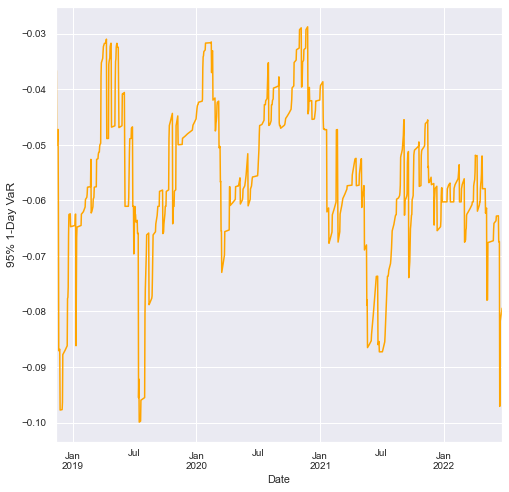

In [49]:
plt.figure(figsize=(8, 8))

# fig.add_subplot(1, 1, 1)

ax1 = btc.loc["BTC"]["ExpW_mc VaR"].dropna().plot(use_index=True, color='orange');

ax1.set_ylabel(f"{95}% 1-Day VaR", fontsize=12)

plt.show()

In [57]:
btc_plot_data = btc[["Return", "EqW VaR", "ExpW_mc VaR" ]].dropna().droplevel(0)

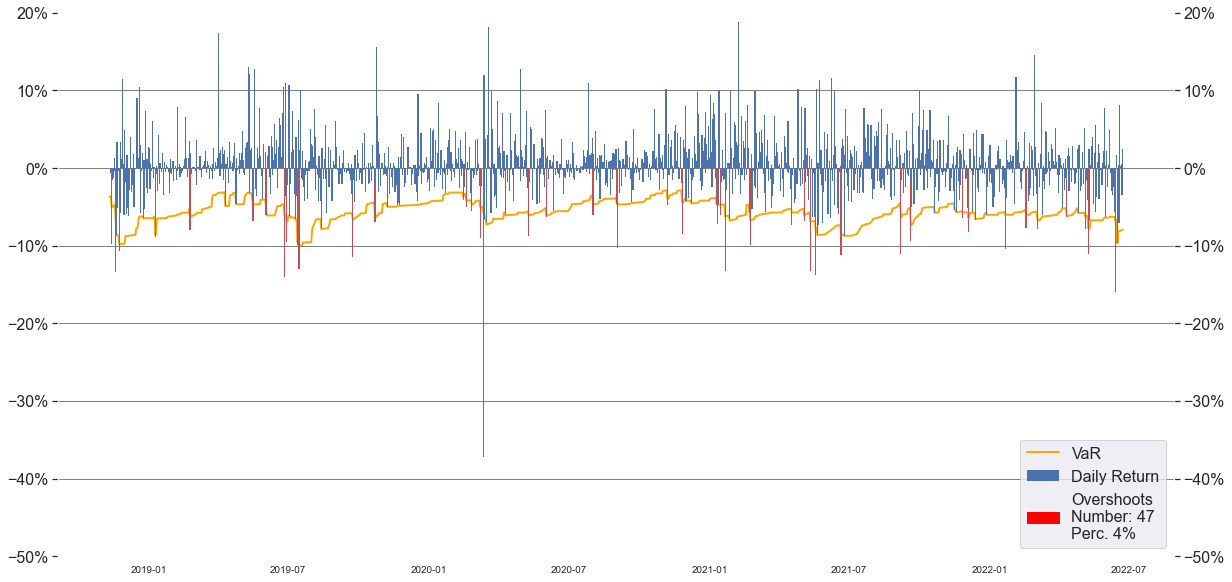

In [54]:
plt.rcParams['figure.figsize']=(20,10) # set the figure size
matplotlib .rcParams['grid.color'] = 'grey'


# plt.style.use('fivethirtyeight') 
fig = plt.figure()
ax1 = fig.subplots()
ax2 = ax1.twinx()  # set up the 2nd axis

var_line = ax1.plot(btc_plot_data["ExpW_mc VaR"]*100,
                      color="orange",
                      linewidth=1.95,
                      label = "VaR")

colors = np.repeat("b", len(btc_plot_data["ExpW_mc VaR"]))
colors[np.where(btc_plot_data.Return<btc_plot_data["ExpW_mc VaR"])[0]] = "r"
colors = list(colors)

return_bars = ax2.bar(btc_plot_data.index,
                      btc_plot_data.Return*100,
                      width=1.5,
                      color=colors,
                      label="Daily Return",
                      edgecolor='none')# alpha=1,

ax2.grid(b=False, axis = "both") 
ax1.grid(b=False, axis="x")

ax1.set_facecolor("white")

ax1.set_ylabel('', fontsize=16)
ax2.set_ylabel('', fontsize=16)
ax1.set_xlabel('', fontsize=16)

# ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=16)
# ax.tick_params(axis=u'both', which=u'both',length=0)
# ax2.spines["bottom"].set_linewidth(4)

ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=16)
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=16)

ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

ax1.set_ylim([-50, 20])
ax2.set_ylim([-50, 20])

handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
        
overshoots = len(np.where(btc_plot_data.Return<btc_plot_data["ExpW_mc VaR"])[0])
percentage_overshoots = len(np.where(btc_plot_data.Return<btc_plot_data["ExpW_mc VaR"])[0])/len(btc_plot_data.Return)

handles.append(mpatches.Patch(color='red', label='The red data'))
labels.append("Overshoots\nNumber: {:}\nPerc. {:.00%}".format(overshoots, percentage_overshoots))



plt.legend(handles,labels, loc=4, ncol = 1, fontsize=16)



plt.show()


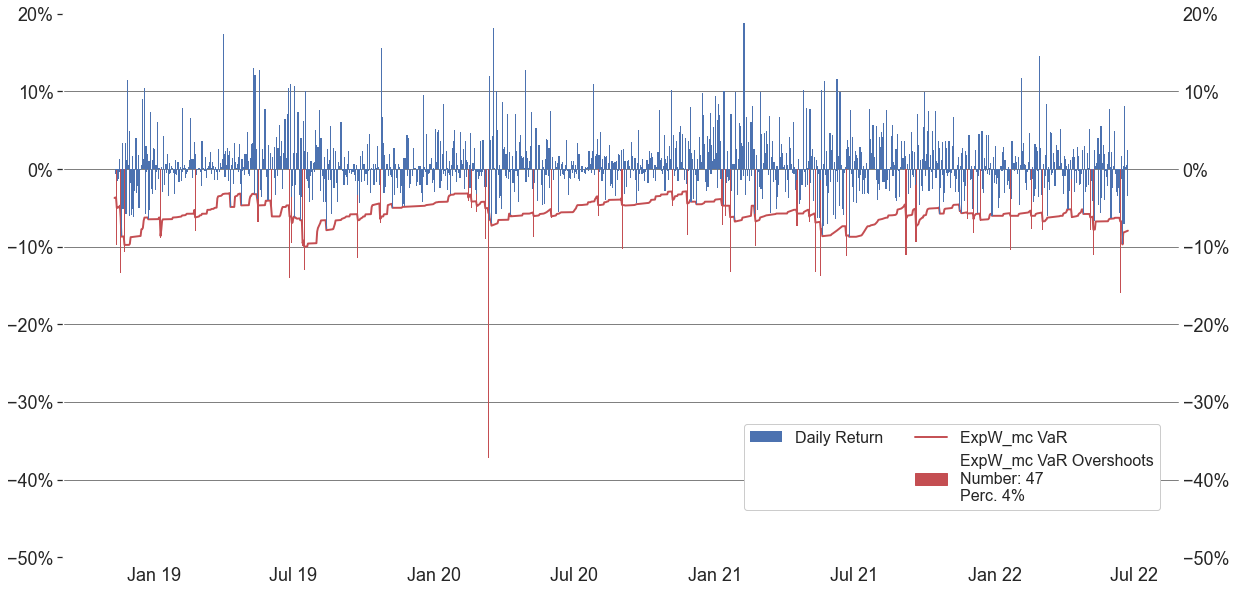

In [55]:
# set figure parameters
plt.rcParams['figure.figsize']=(20,10) # set the figure size
matplotlib .rcParams['grid.color'] = 'grey'

# initialise figure and axes
fig = plt.figure()
ax1 = fig.subplots()
ax2 = ax1.twinx()  # set up the 2nd axis

# first VaR line chart
line_plot_1 = "ExpW_mc VaR"
line_plot_1_color = "r"
var_line = ax1.plot(btc_plot_data[line_plot_1]*100,
                      color=line_plot_1_color,
                      linewidth=1.95,
                      label = line_plot_1)

# conditional colours for profit & loss barchart of overshoots
bar_chart_color = "b"
colors = np.repeat(bar_chart_color, len(btc_plot_data[line_plot_1]))
colors[np.where((btc_plot_data.Return<btc_plot_data[line_plot_1]))] = line_plot_1_color
colors = list(colors)

# profit and loss barchart
return_bars = ax2.bar(btc_plot_data.index,
                      btc_plot_data.Return*100,
                      width=1.5,
                      color=colors,
                      label="Daily Return",
                      edgecolor='none')# alpha=1,

# remove various gridlines
ax2.grid(b=False, axis = "both") 
ax1.grid(b=False, axis="x")

# plot background color
ax1.set_facecolor("white")

# set/remove axis labels
axis_label_fontsize = 16
ax1.set_ylabel('', fontsize=axis_label_fontsize)
ax2.set_ylabel('', fontsize=axis_label_fontsize)
ax1.set_xlabel('', fontsize=axis_label_fontsize)

# ax1 ticks and label formatting
tick_label_fontsize = 18
ax1.tick_params(axis='x', labelsize=tick_label_fontsize)
ax1.tick_params(axis='y', labelsize=tick_label_fontsize)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

# remove ticks for ax1
ax.tick_params(axis=u'both', which=u'both',length=0)

# ax2 ticks and label formatting
ax2.tick_params(axis='y', labelsize=tick_label_fontsize)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

# remove ticks for ax2
ax2.tick_params(axis=u'both', which=u'both',length=0)

# limits for both y axes
ax1.set_ylim([-50, 20])
ax2.set_ylim([-50, 20])

handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

handles.append(mpatches.Patch(color="w", label=''))
labels.append("")

# legends
overshoots_line_1 = len(np.where(btc_plot_data.Return<btc_plot_data[line_plot_1])[0])
percentage_overshoots_line_1 = len(np.where(btc_plot_data.Return<btc_plot_data[line_plot_1])[0])/len(btc_plot_data.Return)
handles.append(mpatches.Patch(color=line_plot_1_color, label=''))
labels.append("{} Overshoots\nNumber: {:}\nPerc. {:.00%}".format(line_plot_1,overshoots_line_1, percentage_overshoots_line_1))

# reorder legend
handles = [handles[i] for i in [1,2,0,3]]
labels = [labels[i] for i in [1,2,0,3]]

# create legend
plt.legend(handles,labels, bbox_to_anchor=(0.99, 0.26), ncol = 2, fontsize=16, facecolor = "w", framealpha = 1)


plt.show()


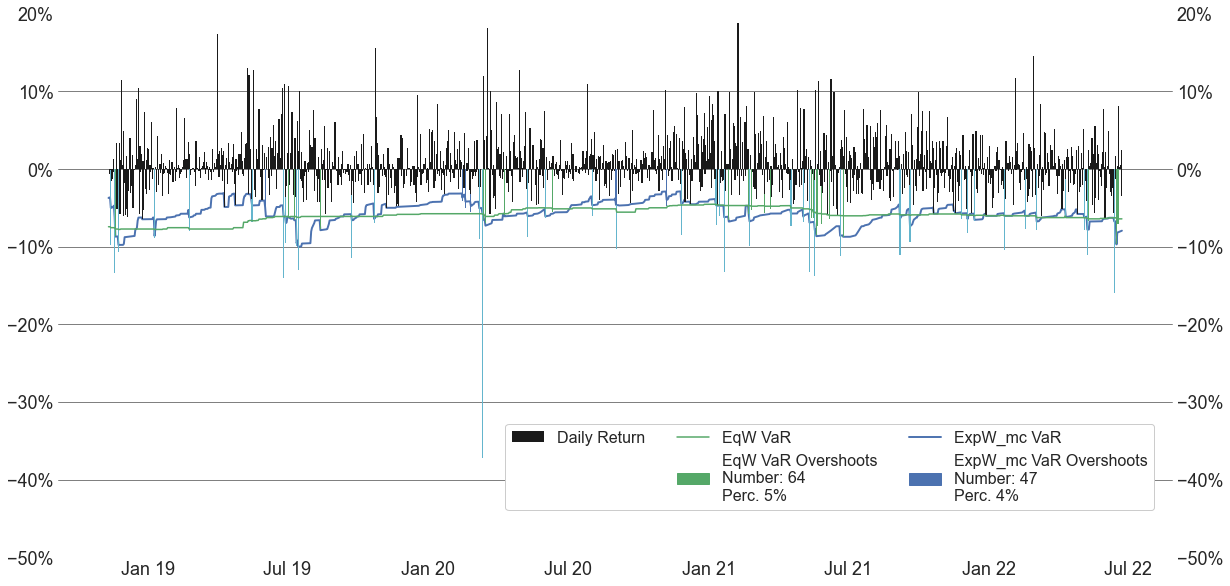

In [56]:
# set figure parameters
plt.rcParams['figure.figsize']=(20,10) # set the figure size
matplotlib .rcParams['grid.color'] = 'grey'

# initialise figure and axes
fig = plt.figure()
ax1 = fig.subplots()
ax2 = ax1.twinx()  # set up the 2nd axis

# first VaR line chart
line_plot_1 = "ExpW_mc VaR"
line_plot_1_color = "b"
var_line = ax1.plot(btc_plot_data[line_plot_1]*100,
                      color=line_plot_1_color,
                      linewidth=1.95,
                      label = line_plot_1)

# second VaR line chart
line_plot_2 = "EqW VaR"
line_plot_2_color = "g"
plt.plot(btc_plot_data[line_plot_2]*100, color =line_plot_2_color , label = line_plot_2)

# conditional colours for profit & loss barchart of overshoots
bar_chart_color = "k"
colors = np.repeat(bar_chart_color, len(btc_plot_data[line_plot_1]))
colors[np.where((btc_plot_data.Return<btc_plot_data[line_plot_1]) & ~(btc_plot_data.Return<btc_plot_data[line_plot_2]))[0]] = line_plot_1_color
colors[np.where(~(btc_plot_data.Return<btc_plot_data[line_plot_1]) & (btc_plot_data.Return<btc_plot_data[line_plot_2]))[0]] = line_plot_2_color
colors[np.where((btc_plot_data.Return<btc_plot_data[line_plot_1]) & (btc_plot_data.Return<btc_plot_data[line_plot_2]))[0]] = 'c'
colors = list(colors)

# profit and loss barchart
return_bars = ax2.bar(btc_plot_data.index,
                      btc_plot_data.Return*100,
                      width=1.5,
                      color=colors,
                      label="Daily Return",
                      edgecolor='none')# alpha=1,

# remove various gridlines
ax2.grid(b=False, axis = "both") 
ax1.grid(b=False, axis="x")

# plot background color
ax1.set_facecolor("white")

# set/remove axis labels
axis_label_fontsize = 16
ax1.set_ylabel('', fontsize=axis_label_fontsize)
ax2.set_ylabel('', fontsize=axis_label_fontsize)
ax1.set_xlabel('', fontsize=axis_label_fontsize)

# ax1 ticks and label formatting
tick_label_fontsize = 18
ax1.tick_params(axis='x', labelsize=tick_label_fontsize)
ax1.tick_params(axis='y', labelsize=tick_label_fontsize)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

# remove ticks for ax1
ax1.tick_params(axis=u'both', which=u'both',length=0)

# ax2 ticks and label formatting
ax2.tick_params(axis='y', labelsize=tick_label_fontsize)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

# remove ticks for ax2
ax2.tick_params(axis=u'both', which=u'both',length=0)

# limits for both y axes
ax1.set_ylim([-50, 20])
ax2.set_ylim([-50, 20])

# labels for legend
handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

handles.append(mpatches.Patch(color="w", label=''))
labels.append("")

# legends
overshoots_line_1 = len(np.where(btc_plot_data.Return<btc_plot_data[line_plot_1])[0])
percentage_overshoots_line_1 = len(np.where(btc_plot_data.Return<btc_plot_data[line_plot_1])[0])/len(btc_plot_data.Return)
handles.append(mpatches.Patch(color=line_plot_1_color, label=''))
labels.append("{} Overshoots\nNumber: {:}\nPerc. {:.00%}".format(line_plot_1,overshoots_line_1, percentage_overshoots_line_1))

overshoots_line_2 = len(np.where(btc_plot_data.Return<btc_plot_data[line_plot_2])[0])
percentage_overshoots_line_2 = len(np.where(btc_plot_data.Return<btc_plot_data[line_plot_2])[0])/len(btc_plot_data.Return)
handles.append(mpatches.Patch(color=line_plot_2_color, label=''))
labels.append("{} Overshoots\nNumber: {:}\nPerc. {:.00%}".format(line_plot_2,overshoots_line_2, percentage_overshoots_line_2))

# reorder legend
handles = [handles[i] for i in [2,3,1,5,0,4]]
labels = [labels[i] for i in [2,3,1,5,0,4]]

# create legend
plt.legend(handles,labels, bbox_to_anchor=(0.99, 0.26), ncol = 3, fontsize=16, facecolor = "w", framealpha = 1)

plt.savefig('var_plot.jpg')  
plt.show()

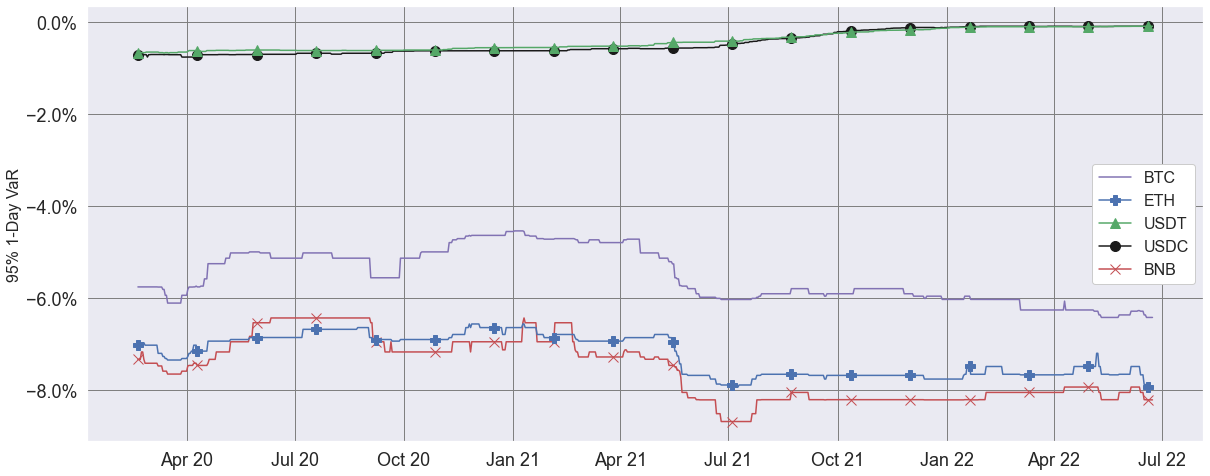

In [58]:
styles = [
    'x',
    '',
    'P',
    'o',
    '^']

colors = ('r', 'm', 'b', 'k', 'g')#, 'y', 'k')

plot_data = top_coins_VaRs

columns = plot_data['EqW VaR'].unstack(level=0).dropna().columns

# fig = plt.figure(figsize=(20, 8))
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot()
colnum=0
for col in columns:
        color = colors[colnum]
        style = styles[colnum]
        plt.plot(plot_data['EqW VaR'].unstack(level=0).dropna()[col]*100, linestyle='-', marker=style, color=color, markersize=10, markevery=50, label = col)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        colnum += 1
        
# set/remove axis labels
axis_label_fontsize = 16
ax.set_ylabel('95% 1-Day VaR', fontsize=axis_label_fontsize)

# ax1 ticks and label formatting
tick_label_fontsize = 18
ax.tick_params(axis='x', labelsize=tick_label_fontsize)
ax.tick_params(axis='y', labelsize=tick_label_fontsize)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# remove ticks for ax1
ax1.tick_params(axis=u'both', which=u'both',length=0)

handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
        
# reorder legend
handles = [handles[i] for i in [1,2,4,3,0]]
labels = [labels[i] for i in [1,2,4,3,0]]
# labels.sort(key=list(["BTC", "ETH", "USDT", "USDC", "BNB"]).index)

# # create legend
plt.legend(handles,labels, loc=0, ncol = 1, fontsize=16, facecolor = "w", framealpha = 1)

plt.show()

In [59]:
top_coins_with_top_market_VaRs = pd.concat([top_coins_VaRs, sp500, gold])

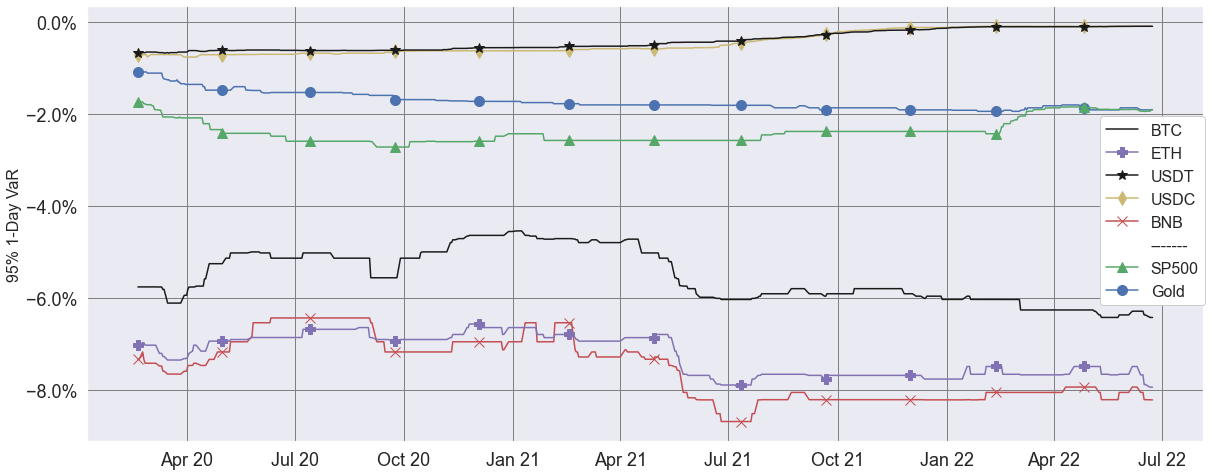

In [60]:
styles = [
    'x',
    '',
    'P',
    'o',
    '^',
    'd',
    '*']

colors = ('r', 'k', 'm', 'b', 'g', 'y', 'k')

plot_data = top_coins_with_top_market_VaRs

columns = plot_data['EqW VaR'].unstack(level=0).dropna().columns

# fig = plt.figure(figsize=(20, 8))
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot()
colnum=0
for col in columns:
        color = colors[colnum]
        style = styles[colnum]
        plt.plot(plot_data['EqW VaR'].unstack(level=0).dropna()[col]*100, linestyle='-', marker=style, color=color, markersize=10, markevery=50, label = col)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        colnum += 1
        
# set/remove axis labels
axis_label_fontsize = 16
ax.set_ylabel('95% 1-Day VaR', fontsize=axis_label_fontsize)

# ax1 ticks and label formatting
tick_label_fontsize = 18
ax.tick_params(axis='x', labelsize=tick_label_fontsize)
ax.tick_params(axis='y', labelsize=tick_label_fontsize)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# remove ticks for ax1
ax1.tick_params(axis=u'both', which=u'both',length=0)

handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
        
# White legend item for market series' title
handles.append(mpatches.Patch(color="w", label=''))
labels.append("-------")
        
# # reorder legend
handles = [handles[i] for i in [1,2,6,5,0,7,4,3]]
labels = [labels[i] for i in [1,2,6,5,0,7,4,3]]
# # labels.sort(key=list(["BTC", "ETH", "USDT", "USDC", "BNB"]).index)

# # create legend
plt.legend(handles,labels,  bbox_to_anchor=(0.9, 0.53), ncol = 1, fontsize=16, facecolor = "w", framealpha = 1)

plt.show()

## Correlation Plots

Correlation of the two largest cryptocurrencies and major market indices and other financial timeseries such as Gold and a number of major currency pairs.

In [37]:
coins_with_market_pivot = coins_with_market.reset_index().pivot('Date','Symbol')["Return"]
coins_with_market_pivot = coins_with_market_pivot[['BTC',"ETH","SP500","MSCI.WORLD","STOXX600","Gold","Oil","CDX", "EURUSD", "USDJPY", "GBPUSD", "EURGBP"]]# + [col for col in coins_with_market_pivot if col not in ['BTC', 'ETH']]]

corr_data = coins_with_market_pivot.corr()
corr_data.index.name = None
corr_data

Symbol,BTC,ETH,SP500,MSCI.WORLD,STOXX600,Gold,Oil,CDX,EURUSD,USDJPY,GBPUSD,EURGBP
BTC,1.000000,0.765926,0.249095,0.227813,0.201375,0.090848,0.082079,0.412375,0.039112,0.010859,-0.006237,0.042609
ETH,0.765926,1.000000,0.285334,0.272378,0.229772,0.086713,0.092647,0.387393,0.040967,0.026783,0.023436,0.010617
SP500,0.249095,0.285334,1.000000,0.776691,0.621686,0.041583,0.288856,0.630978,0.114107,0.067543,0.115067,-0.028767
MSCI.WORLD,0.227813,0.272378,0.776691,1.000000,0.619548,0.092192,0.273253,0.415223,0.118529,0.069856,0.113723,-0.021720
STOXX600,0.201375,0.229772,0.621686,0.619548,1.000000,0.001453,0.308706,0.290983,-0.002843,0.180453,0.067830,-0.079804
Gold,0.090848,0.086713,0.041583,0.092192,0.001453,1.000000,0.105603,-0.046919,0.175689,-0.172356,0.147706,-0.006459
Oil,0.082079,0.092647,0.288856,0.273253,0.308706,0.105603,1.000000,-0.076079,-0.021716,0.087197,0.057285,-0.083894
CDX,0.412375,0.387393,0.630978,0.415223,0.290983,-0.046919,-0.076079,1.000000,0.331620,-0.247815,0.353884,-0.038601
EURUSD,0.039112,0.040967,0.114107,0.118529,-0.002843,0.175689,-0.021716,0.331620,1.000000,-0.375642,0.586659,0.233413
USDJPY,0.010859,0.026783,0.067543,0.069856,0.180453,-0.172356,0.087197,-0.247815,-0.375642,1.000000,-0.251943,-0.052019


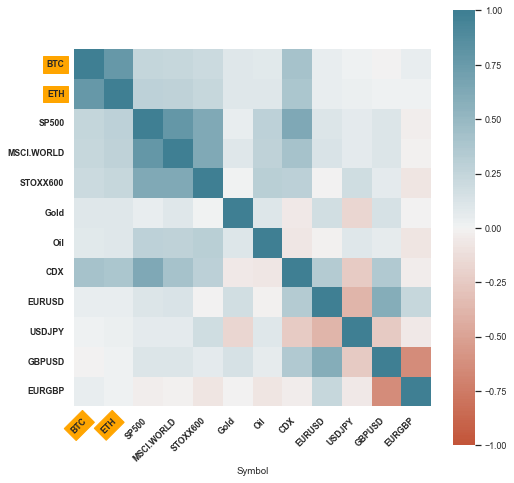

In [38]:
plt.figure(figsize=(8, 8))
sns.set(font_scale=.8)

hm_1 = sns.heatmap(
    corr_data, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
hm_1.set_xticklabels(
    hm_1.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontweight = "bold"
);

hm_1.set_yticklabels(
    hm_1.get_yticklabels(),
    #rotation=45,
    #horizontalalignment='right',
    fontweight = "bold"
);

xticklabels = [t for t in hm_1.get_xticklabels()]
yticklabels = [t for t in hm_1.get_yticklabels()]
for l in set(df.index.get_level_values(level=0))  & set(coins_with_market.reset_index()["Symbol"]):
    i = corr_data.columns.get_loc(l)
    # yticklabels[i].set_color("black")
    xticklabels[i].set_backgroundcolor("orange")
    yticklabels[i].set_backgroundcolor("orange")
    xticklabels[i].set_fontweight("bold")
    yticklabels[i].set_fontweight("bold")


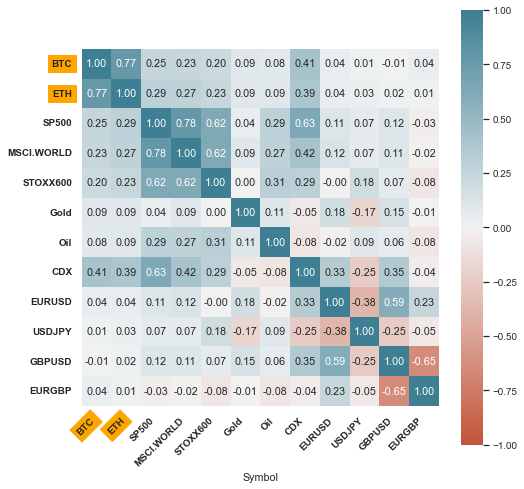

In [39]:
plt.figure(figsize=(8, 8))
sns.set(font_scale=.9)

hm_2 = sns.heatmap(corr_data,
                   cmap=sns.diverging_palette(20, 220, n=200),
                   vmin=-1,
                   vmax=1,
                   center=0,
                   annot=True,
                   square=True,
                   fmt='.2f')

hm_2.set_xticklabels(
    hm_2.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontweight = "bold"
);

hm_2.set_yticklabels(
    hm_2.get_yticklabels(),
    #rotation=45,
    #horizontalalignment='right',
    fontweight = "bold"
);


xticklabels = [t for t in hm_2.get_xticklabels()]
yticklabels = [t for t in hm_2.get_yticklabels()]
for l in set(df.index.get_level_values(level=0))  & set(coins_with_market.reset_index()["Symbol"]):
    i = corr_data.columns.get_loc(l)
    # yticklabels[i].set_color("black")
    xticklabels[i].set_backgroundcolor("orange")
    yticklabels[i].set_backgroundcolor("orange")
    # xticklabels[i].set_fontweight("bold")
    # yticklabels[i].set_fontweight("bold")

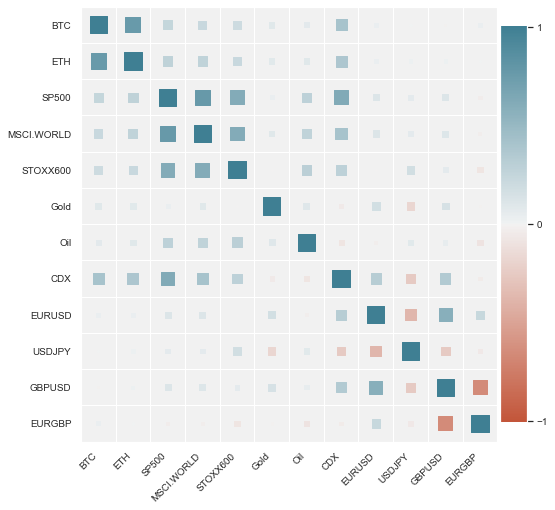

In [40]:
plt.figure(figsize=(8, 8))
hm_3 = corrplot(corr_data, size_scale=300)

## Autocorrelation

In [61]:
AC = df.groupby(level = "Symbol")['Return'].apply(pd.Series.autocorr).reset_index(name='autocorrelation')
AC.head()
AC.sort_values(by=['autocorrelation'], ascending = False)

,Symbol,autocorrelation
39,GALA,0.133794
91,XEC,0.076153
79,TRX,0.068902
27,DOGE,0.057975
50,KCS,0.057626
...,...,...
24,DAI,-0.441483
17,BUSD,-0.474139
80,TUSD,-0.493799
21,COMP,NaN


## ARIMA and GARCH VaR

In [102]:
def garch_VaR(coin, alpha, history, ar_order, garch_order=(1,1), horizon=1, dist="NORM"):
    
    if coin.index.names[0] == "Symbol":
        coin_data = coin.droplevel("Symbol").loc[:,["Return"]].dropna()
    else:
        coin_data = coin.loc[:,["Return"]].dropna()
        
    coin_data = coin_data.sort_values(by=["Date"], ascending = True)
    date_index = coin_data.index.get_level_values("Date")
    
    nforecasts = horizon
    
    # data and window size
    n_obs = len(coin_data)
    window = history
    window_break_init = date_index[window-1]
    window_break = window_break_init
    
    # ar_order = (2, 0, 1)
    # garch_p = 2
    # garch_q = 2
    
    # ARIMA training and in-sample residuals
    ar_mod = SARIMAX(coin_data[:window_break], order = ar_order)
    ar_mod_results = ar_mod.fit()
    coin_data["yhat"] = ar_mod_results.fittedvalues
    coin_data["ar_resid"] = ar_mod_results.resid
    
    # first out of sample AR forecast and residual
    coin_data.loc[date_index[window],"yhat"] = ar_mod_results.forecast(steps=nforecasts).values
    coin_data.loc[date_index[window],"ar_resid"] = coin_data.loc[date_index[window],"Return"]-coin_data.loc[date_index[window],"yhat"]

    # Garch Model
    resid_model = arch_model(coin_data.loc[:window_break,"ar_resid"], p = garch_order[0], q = garch_order[1], vol = "GARCH")
    resid_model_results = resid_model.fit(last_obs=window_break, disp="off")

    coin_data.loc[:, "GARCH vol"] = resid_model_results.forecast(start=window_break, horizon=nforecasts).residual_variance
    
    t=0

    while window_break < date_index[len(date_index)-2]:
        
        # increment
        t = t+1
        window_break = date_index[window-1 + t]

        # re-train garch model on expanded window 
        resid_model = arch_model(coin_data.loc[:window_break,"ar_resid"], p = garch_order[0], q = garch_order[1], vol = "GARCH")
        resid_model_results = resid_model.fit(last_obs=window_break, disp="off")

        # store garch variance
        coin_data.loc[window_break, "GARCH vol"] = resid_model_results.forecast(start=window_break, horizon=nforecasts).residual_variance.values[-1]

        # re-train AR model on expanding window
        ar_mod = SARIMAX(coin_data.loc[:window_break, ["Return"]], order = ar_order)
        ar_mod_results = ar_mod.fit()

        coin_data.loc[date_index[window + t], "yhat"] = ar_mod_results.forecast(1).values
        coin_data.loc[date_index[window + t], "ar_resid"]  = coin_data.loc[date_index[window + t],"Return"]-coin_data.loc[date_index[window + t],"yhat"]

    coin_data["GARCH vol"] = coin_data["GARCH vol"].shift(1)
    
    distribution_quantile = norm.ppf(alpha)
    coin_data["GARCH VaR"] = -coin_data["yhat"]+distribution_quantile*np.sqrt(coin_data["GARCH vol"])

    return coin_data

In [147]:
# btc_Garch_VaR = garch_VaR(btc, alpha=0.05, history=500, ar_order=(1,0,0), garch_order=(1,1), horizon=1)
# btc_Garch_VaR
# btc_Garch_VaR.to_csv("btc_garch_var.csv")

In [149]:
btc_Garch_VaR = pd.read_csv("btc_garch_var.csv")
btc_Garch_VaR['Date'] = pd.to_datetime(btc_Garch_VaR['Date'])
btc_Garch_VaR.set_index(["Date"], inplace=True)
btc_Garch_VaR
#btc_Garch_VaR.loc[:,"GARCH VaR":"GARCH VaR"]

,Return,yhat,ar_resid,GARCH vol,GARCH VaR
Date,,,,,
2017-06-30,-0.023030,0.000000,-0.023030,NaN,NaN
2017-07-01,-0.018659,-0.000496,-0.018163,NaN,NaN
2017-07-02,0.029541,-0.000401,0.029943,NaN,NaN
2017-07-03,0.022977,0.000636,0.022341,NaN,NaN
2017-07-04,0.014656,0.000494,0.014162,NaN,NaN
...,...,...,...,...,...
2022-06-19,0.080748,0.001973,0.078774,0.003131,-0.094015
2022-06-20,0.002251,-0.002385,0.004636,0.003257,-0.091488
2022-06-21,0.005391,-0.000066,0.005458,0.002916,-0.088755


In [145]:
btc_plot_data = pd.concat([btc.loc["BTC"], btc_Garch_VaR.loc[:,"GARCH VaR":"GARCH VaR"]], axis=1)[["Return", "EqW VaR", "ExpW_mc VaR", "GARCH VaR"]].dropna()

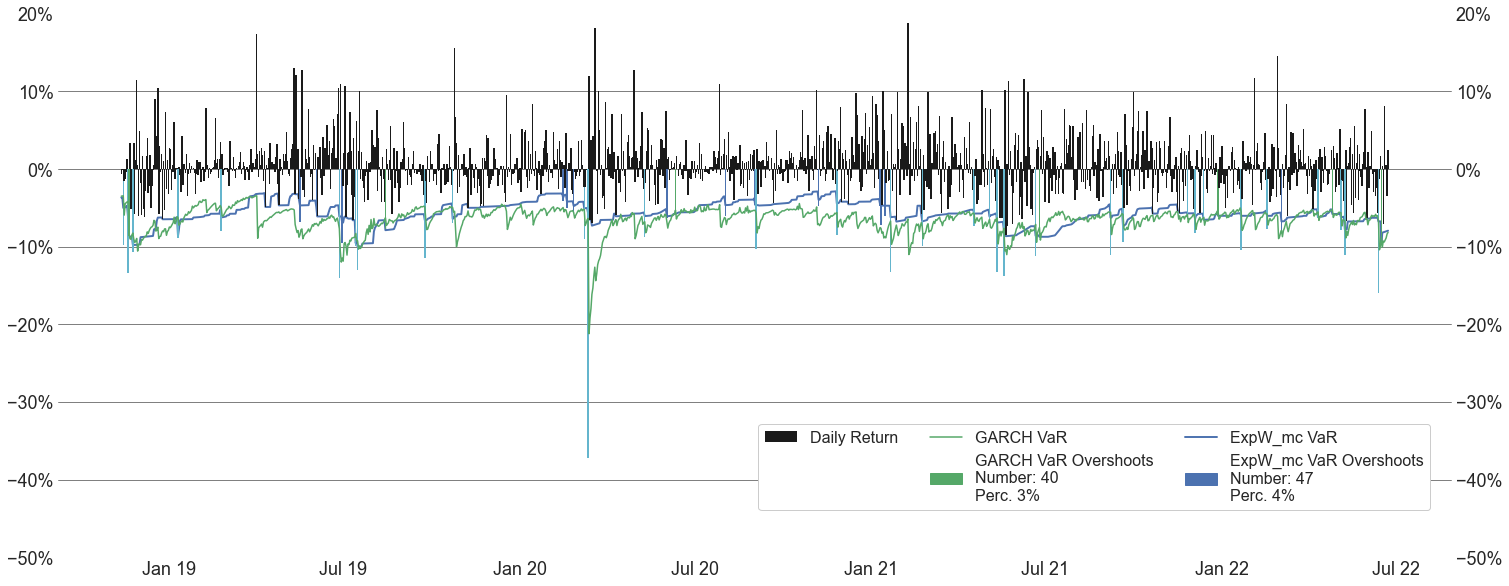

In [146]:
# set figure parameters
plt.rcParams['figure.figsize']=(25,10) # set the figure size
matplotlib .rcParams['grid.color'] = 'grey'

# initialise figure and axes
fig = plt.figure()
ax1 = fig.subplots()
ax2 = ax1.twinx()  # set up the 2nd axis

# first VaR line chart
line_plot_1 = "ExpW_mc VaR"
line_plot_1_color = "b"
var_line = ax1.plot(btc_plot_data[line_plot_1]*100,
                      color=line_plot_1_color,
                      linewidth=1.95,
                      label = line_plot_1)

# second VaR line chart
line_plot_2 = "GARCH VaR"
line_plot_2_color = "g"
plt.plot(btc_plot_data[line_plot_2]*100, color =line_plot_2_color , label = line_plot_2)

# conditional colours for profit & loss barchart of overshoots
bar_chart_color = "k"
colors = np.repeat(bar_chart_color, len(btc_plot_data[line_plot_1]))
colors[np.where((btc_plot_data.Return<btc_plot_data[line_plot_1]) & ~(btc_plot_data.Return<btc_plot_data[line_plot_2]))[0]] = line_plot_1_color
colors[np.where(~(btc_plot_data.Return<btc_plot_data[line_plot_1]) & (btc_plot_data.Return<btc_plot_data[line_plot_2]))[0]] = line_plot_2_color
colors[np.where((btc_plot_data.Return<btc_plot_data[line_plot_1]) & (btc_plot_data.Return<btc_plot_data[line_plot_2]))[0]] = 'c'
colors = list(colors)

# profit and loss barchart
return_bars = ax2.bar(btc_plot_data.index,
                      btc_plot_data.Return*100,
                      width=1.5,
                      color=colors,
                      label="Daily Return",
                      edgecolor='none')# alpha=1,

# remove various gridlines
ax2.grid(b=False, axis = "both") 
ax1.grid(b=False, axis="x")

# plot background color
ax1.set_facecolor("white")

# set/remove axis labels
axis_label_fontsize = 16
ax1.set_ylabel('', fontsize=axis_label_fontsize)
ax2.set_ylabel('', fontsize=axis_label_fontsize)
ax1.set_xlabel('', fontsize=axis_label_fontsize)

# ax1 ticks and label formatting
tick_label_fontsize = 18
ax1.tick_params(axis='x', labelsize=tick_label_fontsize)
ax1.tick_params(axis='y', labelsize=tick_label_fontsize)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

# remove ticks for ax1
ax1.tick_params(axis=u'both', which=u'both',length=0)

# ax2 ticks and label formatting
ax2.tick_params(axis='y', labelsize=tick_label_fontsize)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

# remove ticks for ax2
ax2.tick_params(axis=u'both', which=u'both',length=0)

# limits for both y axes
ax1.set_ylim([-50, 20])
ax2.set_ylim([-50, 20])

# labels for legend
handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

handles.append(mpatches.Patch(color="w", label=''))
labels.append("")

# legends
overshoots_line_1 = len(np.where(btc_plot_data.Return<btc_plot_data[line_plot_1])[0])
percentage_overshoots_line_1 = len(np.where(btc_plot_data.Return<btc_plot_data[line_plot_1])[0])/len(btc_plot_data.Return)
handles.append(mpatches.Patch(color=line_plot_1_color, label=''))
labels.append("{} Overshoots\nNumber: {:}\nPerc. {:.00%}".format(line_plot_1,overshoots_line_1, percentage_overshoots_line_1))

overshoots_line_2 = len(np.where(btc_plot_data.Return<btc_plot_data[line_plot_2])[0])
percentage_overshoots_line_2 = len(np.where(btc_plot_data.Return<btc_plot_data[line_plot_2])[0])/len(btc_plot_data.Return)
handles.append(mpatches.Patch(color=line_plot_2_color, label=''))
labels.append("{} Overshoots\nNumber: {:}\nPerc. {:.00%}".format(line_plot_2,overshoots_line_2, percentage_overshoots_line_2))

# reorder legend
handles = [handles[i] for i in [2,3,1,5,0,4]]
labels = [labels[i] for i in [2,3,1,5,0,4]]

# create legend
plt.legend(handles,labels, bbox_to_anchor=(0.99, 0.26), ncol = 3, fontsize=16, facecolor = "w", framealpha = 1)

plt.savefig('var_plot.jpg')  
plt.show()

# *Trash*

<AxesSubplot:xlabel='Date'>

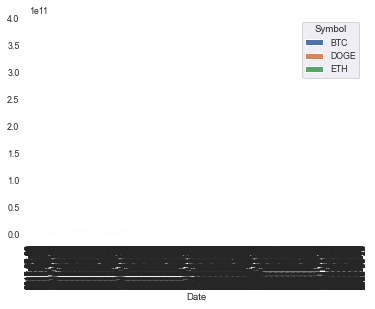

In [87]:
sub_df = df.loc[["BTC","ETH","DOGE"]]
sub_df = sub_df.groupby(['Date','Symbol'])['Volume'].sum().unstack()
sub_df.plot(kind='bar',stacked=True)


Parallel Processing of VaR of all coins

In [1022]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import arch

returns = df.loc["GALA"]["Return"].dropna()

# train, test = train_test_split(returns, train_size=450)
# test

# # Fit your model
# model = pm.auto_arima(returns, seasonal=True, m=12)



# fit ARIMA on returns 
# arima_model_fitted = pm.auto_arima(returns)
arima_model_fitted = pm.ARIMA(returns, order=(1,0,0))
# p, d, q = arima_model_fitted.order
arima_residuals = arima_model_fitted.arima_res_.resid
arima_residuals

# # fit a GARCH(1,1) model on the residuals of the ARIMA model
# garch = arch.arch_model(arima_residuals, p=1, q=1)
# garch_fitted = garch.fit()

# # Use ARIMA to predict mu
# predicted_mu = arima_model_fitted.predict(n_periods=1)[0]
# # Use GARCH to predict the residual
# garch_forecast = garch_fitted.forecast(horizon=1)
# predicted_et = garch_forecast.mean['h.1'].iloc[-1]
# # Combine both models' output: yt = mu + et
# # prediction = 
# predicted_mu + predicted_et

# returns

TypeError: __init__() got multiple values for argument 'order'

In [ ]:
import multiprocessing
from multiprocessing import Pool, cpu_count
from functools import partial

lambda_ = 0.98
alpha=0.05
history=1819
exponential_weighted=True
mass_centered=True
args = [lambda_,alpha,history,exponential_weighted,mass_centered]

dfGrouped = other_coins.groupby(level = "Symbol")
def applyParallel(dfGrouped, other_coins):
    with Pool(cpu_count()) as p:
        # ret_list = p.starmap(weighted_hist_VaR, zip([group for name, group in dfGrouped], np.repeat(lambda_,2), np.repeat(alpha,2), np.repeat(history,2), np.repeat(exponential_weighted,2), np.repeat(mass_centered,2)))
        ret_list = p.map(partial(weighted_hist_VaR, args), [group for name, group in dfGrouped])
    return pandas.concat(ret_list)
ret_list = applyParallel(dfGrouped, other_coins)
ret_list

In [ ]:
def weighted_hist_VaR_DISCONTINUED(port, lambda_, alpha, exponential_weighted=True, mass_centered=True):
    
    # Number of observations for a crypto
    k = port.shape[0]

    # Compute the equally weighted and exponentially weighted probabilites
    port.loc[port.index,"equal_prob"] = 1/k
    # Weighted probabilites are done so with respect to how 'recent' and observation is, more recent is assigned more weight
    port.loc[port.index,"weighted_prob"] = (1-lambda_)*(pow(lambda_,port.loc[port.index,"Recency"]-1)/(1-pow(lambda_,k)))
    
    # Compute the equally weighted and exponentially weighted cumulative probabilites
    port["cumul_equal_prob"] = port['equal_prob'].cumsum()
    port['cumul_weighted_prob'] = port['weighted_prob'].cumsum()
    
    # Rank the returns from lowest to highest, the key step in Historical VaR estimation
    port = port.sort_values(by="Return")
    
    # Capture the cumulative probabilites and corresponding crypto returns
    returns = np.array(port["Return"])
    
    ## EXP-WEIGHTED VAR
    if exponential_weighted:
        
        cumul_weighted_prob = np.array(port["cumul_weighted_prob"])
  
        ## MASS CENTERED VAR 
        if mass_centered:
            # Construct and array to the corresponding midpoints
            cumul_weighted_prob_mid = (cumul_weighted_prob[:-1] + cumul_weighted_prob[1:])/2
            returns_mid = (returns[:-1] + returns[1:])/2

            # construct array to hold cumuulative probabilities, their returnsa and resepctive midpoints
            cumul_weighted_prob_mass_center = [None]*(len(cumul_weighted_prob)+len(cumul_weighted_prob_mid))
            returns_mass_center = [None]*(len(returns)+len(returns_mid))

            # Concatenate the midpoint to their respective arrays also adding the first value of 0% and -Inf
            cumul_weighted_prob_mass_center[::2] = cumul_weighted_prob
            cumul_weighted_prob_mass_center[1::2] = cumul_weighted_prob_mid
            cumul_weighted_prob_mass_center = [0] + cumul_weighted_prob_mass_center
            returns_mass_center[::2] = returns
            returns_mass_center[1::2] = returns_mid
            returns_mass_center = [float("Inf")] + returns_mass_center

            # Interpolation to find the alpha% correpsoning Return
            x = cumul_weighted_prob_mass_center
            y = returns_mass_center
            mass_center_exponential_VaR_interpolator = interpolate.interp1d(x, y)

            # Interpolationg for alpha
            VaR = mass_center_exponential_VaR_interpolator(alpha)
       
        # STANDARD Weighted VAR
        else:
            # Interpolation to find the alpha% correpsoning Return
            x = cumul_weighted_prob
            y = returns
            exponential_VaR_interpolator = interpolate.interp1d(x, y)
            
            # Interpolationg for alpha
            VaR = exponential_VaR_interpolator(alpha)
            
    ## EQUALLY WEIGHTED VAR 
    else:
        cumul_equal_prob = np.array(port["cumul_equal_prob"])
        
        # Interpolation to find the alpha% correpsoning Return
        x = cumul_equal_prob
        y = returns
        VaR_interpolator = interpolate.interp1d(x, y)

        # Interpolationg for alpha
        VaR = Exp_VaR_interpolator(alpha)
    
    return VaR


In [ ]:
corr_data_melt = corr_data.where(pd.np.triu(pd.np.ones(corr_data.shape), k=0).astype(bool)).stack().reset_index()
corr_data_melt

,level_0,Symbol,0
0,BTC,BTC,1.000000
1,BTC,CDX,0.412375
2,BTC,ETH,0.765926
3,BTC,EURGBP=X,0.042609
4,BTC,EURUSD,0.039112
...,...,...,...
73,SP500,STOXX600,0.621686
74,SP500,USDJPY,0.067543
75,STOXX600,STOXX600,1.000000
76,STOXX600,USDJPY,0.180453


[Text(14245.0, 0, 'FY 2010'),
 Text(14610.0, 0, 'FY 2011'),
 Text(14975.0, 0, 'FY 2012'),
 Text(15340.0, 0, 'FY 2013'),
 Text(15706.0, 0, 'FY 2014'),
 Text(16071.0, 0, 'FY 2015'),
 Text(16436.0, 0, '')]

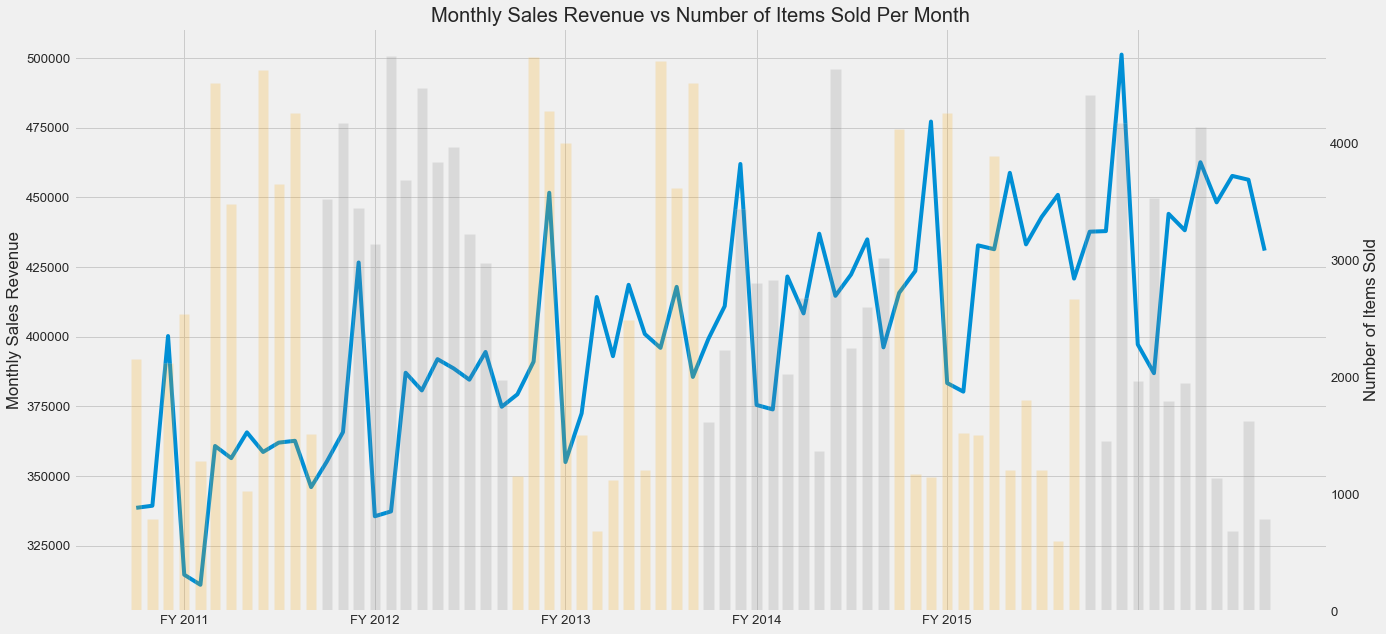

In [343]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline # needed for jupyter notebooks
plt.rcParams['figure.figsize']=(20,10) # set the figure size
plt.style.use('fivethirtyeight') # using the fivethirtyeight matplotlib theme
sales = pd.read_csv('sales.csv') # Read the data in
sales.Date = pd.to_datetime(sales.Date) #set the date column to datetime
sales.set_index('Date', inplace=True) #set the index to the date column
# now the hack for the multi-colored bar chart: 
# create fiscal year dataframes covering the timeframes you are looking for. In this case,
# the fiscal year covered October - September.
# --------------------------------------------------------------------------------
# Note: This should be set up as a function, but for this small amount of data,
# I just manually built each fiscal year. This is not very pythonic and would
# suck to do if you have many years of data, but it isn't bad for a few years of data. 
# --------------------------------------------------------------------------------
fy10_all = sales[(sales.index >= '2009-10-01') & (sales.index < '2010-10-01')]
fy11_all = sales[(sales.index >= '2010-10-01') & (sales.index < '2011-10-01')]
fy12_all = sales[(sales.index >= '2011-10-01') & (sales.index < '2012-10-01')]
fy13_all = sales[(sales.index >= '2012-10-01') & (sales.index < '2013-10-01')]
fy14_all = sales[(sales.index >= '2013-10-01') & (sales.index < '2014-10-01')]
fy15_all = sales[(sales.index >= '2014-10-01') & (sales.index < '2015-10-01')]
# Let's build our plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # set up the 2nd axis
ax1.plot(sales.Sales_Dollars) #plot the Revenue on axis #1
# the next few lines plot the fiscal year data as bar plots and changes the color for each.
ax2.bar(fy10_all.index, fy10_all.Quantity,width=20, alpha=0.2, color='orange')
ax2.bar(fy11_all.index, fy11_all.Quantity,width=20, alpha=0.2, color='gray')
ax2.bar(fy12_all.index, fy12_all.Quantity,width=20, alpha=0.2, color='orange')
ax2.bar(fy13_all.index, fy13_all.Quantity,width=20, alpha=0.2, color='gray')
ax2.bar(fy14_all.index, fy14_all.Quantity,width=20, alpha=0.2, color='orange')
ax2.bar(fy15_all.index, fy15_all.Quantity,width=20, alpha=0.2, color='gray')
ax2.grid(b=False) # turn off grid #2
ax1.set_title('Monthly Sales Revenue vs Number of Items Sold Per Month')
ax1.set_ylabel('Monthly Sales Revenue')
ax2.set_ylabel('Number of Items Sold')
# Set the x-axis labels to be more meaningful than just some random dates.
labels = ['FY 2010', 'FY 2011','FY 2012', 'FY 2013','FY 2014', 'FY 2015']
ax1.axes.set_xticklabels(labels)